https://github.com/Felflare/entity-recognition-datasets

In [50]:
import pandas as pd
import numpy as np

In [51]:
def txt_reader(inpt_file):
    f = open(inpt_file, "r")
    tok_lst = []
    label_lst = []
    for ix, x in enumerate(f):
        if x == '\n':
            tok_lst.append('')
            label_lst.append('')
            continue
        line = x.split()
        tok = line[0]
        try:
            label = line[-1]
        except:
            print(line, ix)
        tok_lst.append(tok)
        label_lst.append(label)
    f.close()
    d = {'token':tok_lst,'ner':label_lst}
    df = pd.DataFrame(d, columns=['token','ner'])
    return df

In [52]:
AnEM_train = txt_reader("/Users/sdeshpande/Desktop/entity-recognition-datasets/data/AnEM/CONLL-format/data/AnEM.train")
AnEM_test = txt_reader("/Users/sdeshpande/Desktop/entity-recognition-datasets/data/AnEM/CONLL-format/data/AnEM.test")

In [53]:
AnEM_train = AnEM_train.replace("",np.nan)
AnEM_train.dropna(inplace = True)
AnEM_train.columns = ["word", "tag"]

In [54]:
AnEM_train.head()

,word,tag
0,Ventricular,B-Multi-tissue_structure
1,fibrillation,O
2,due,O
3,to,O
4,long,O


In [55]:
AnEM_train.shape

(71697, 2)

In [56]:
AnEM_test = AnEM_test.replace("",np.nan)
AnEM_test.dropna(inplace = True)
AnEM_test.columns = ["word", "tag"]

In [57]:
AnEM_test.head()

,word,tag
0,[,O
1,Histopathologic,O
2,examination,O
3,of,O
4,rectal,B-Pathological_formation


In [58]:
AnEM_test.shape

(45939, 2)

In [59]:
AnEM_train = AnEM_train.append(AnEM_test, ignore_index=True)
AnEM_train.shape

(117636, 2)

In [60]:
AnEM_train.head()

,word,tag
0,Ventricular,B-Multi-tissue_structure
1,fibrillation,O
2,due,O
3,to,O
4,long,O


In [61]:
doc = AnEM_train.word.tolist()
doc = " ".join(doc)

In [62]:
import plac
from spacy.lang.en import English
from spacy.matcher import PhraseMatcher
from spacy.tokens import Doc, Span, Token
import spacy
nlp = spacy.load('en_core_web_md')

/Users/sdeshpande/opt/anaconda3/lib/python3.8/site-packages/spacy/util.py:275: UserWarning: [W031] Model 'en_core_web_md' (2.2.5) requires spaCy v2.2 and is incompatible with the current spaCy version (2.3.2). This may lead to unexpected results or runtime errors. To resolve this, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


In [63]:
doc = nlp(doc)

In [64]:
sentences = []
for sent_i, sent in enumerate(doc.sents):
    for token in sent:
        sentences.append((sent_i, token.text))
        
df2 = pd.DataFrame(sentences)
df2.columns = ["sentence_number","word"]
df2.head()

,sentence_number,word
0,0,Ventricular
1,0,fibrillation
2,0,due
3,0,to
4,0,long


In [66]:
AnEM_train_merged = AnEM_train.merge(df2, left_index=True, right_index=True, how='inner')

In [67]:
print(AnEM_train_merged.head())

         word_x                       tag  sentence_number        word_y
0   Ventricular  B-Multi-tissue_structure                0   Ventricular
1  fibrillation                         O                0  fibrillation
2           due                         O                0           due
3            to                         O                0            to
4          long                         O                0          long


In [68]:
AnEM_train_merged.drop(["word_y"], axis = 1, inplace = True)

In [69]:
AnEM_train_merged.columns = ["word","tag", "Sentence #"]

In [70]:
len(AnEM_train_merged)

117636

In [71]:
tags = list(AnEM_train_merged.tag.unique())
tags

['B-Multi-tissue_structure',
 'O',
 'B-Organism_substance',
 'B-Organism_subdivision',
 'B-Organ',
 'I-Multi-tissue_structure',
 'B-Cellular_component',
 'I-Cellular_component',
 'B-Cell',
 'I-Cell',
 'B-Immaterial_anatomical_entity',
 'B-Tissue',
 'I-Tissue',
 'B-Pathological_formation',
 'B-Anatomical_system',
 'I-Organism_substance',
 'I-Anatomical_system',
 'I-Pathological_formation',
 'I-Immaterial_anatomical_entity',
 'I-Organ',
 'I-Organism_subdivision',
 'B-Developing_anatomical_structure',
 'I-Developing_anatomical_structure']

In [72]:
import matplotlib.pyplot as plt
import seaborn as sns

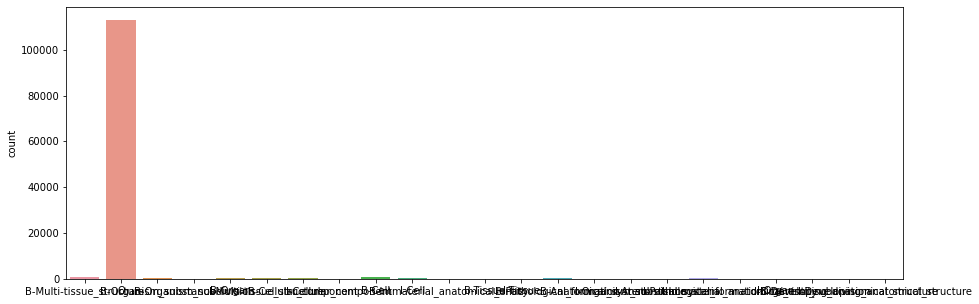

In [73]:
plt.figure(figsize=(15, 5))
sns.countplot(AnEM_train_merged.tag.values)

In [74]:
num_tags = len(tags)
num_tags

23

In [75]:
agg_func = lambda s: [(w, t) for w, t in zip(s["word"].values.tolist(), s["tag"].values.tolist())]
group = AnEM_train_merged.groupby("Sentence #").apply(agg_func)
lines = [s for s in group]

In [76]:
lines[0]

[('Ventricular', 'B-Multi-tissue_structure'),
 ('fibrillation', 'O'),
 ('due', 'O'),
 ('to', 'O'),
 ('long', 'O'),
 ('QT', 'O'),
 ('syndrome', 'O'),
 ('probably', 'O'),
 ('caused', 'O'),
 ('by', 'O'),
 ('clindamycin', 'O'),
 ('.', 'O')]

In [77]:
sentences = [[tokens[0] for tokens in line] for line in lines]
tags = [[tokens[1] for tokens in line] for line in lines]

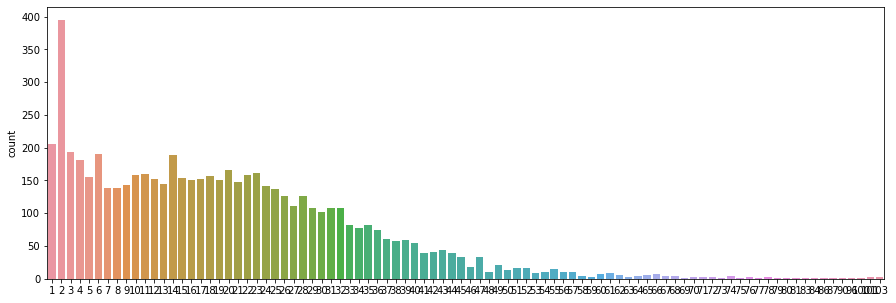

In [78]:
sen_lengths = [len(sent) for sent in sentences]
plt.figure(figsize=(15, 5))
sns.countplot(sen_lengths)

In [79]:
import os
import time
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data

from transformers import BertTokenizer, BertModel

from itertools import chain
from collections import Counter
from sklearn import metrics
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns

In [80]:
MAX_LEN = 60
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

In [81]:
device = torch.device('cpu')
device

device(type='cpu')

In [82]:
# get the special tokens, it is required to use these while encoding in Field
init_token = tokenizer.cls_token
pad_token = tokenizer.pad_token
unk_token = tokenizer.unk_token

init_token_idx = tokenizer.convert_tokens_to_ids(init_token)
pad_token_idx = tokenizer.convert_tokens_to_ids(pad_token)
unk_token_idx = tokenizer.convert_tokens_to_ids(unk_token)

print(init_token_idx, pad_token_idx, unk_token_idx)

101 0 100


In [83]:
# limit the input tokens to max length - 1, [CLS] is the initial token
def convert_to_id(tokens, tokenizer, max_input_length=MAX_LEN):
    tokens = tokens[:max_input_length-1]
    tokens = [init_token_idx] + tokenizer.convert_tokens_to_ids(tokens)
    return tokens

def cut_tags(tag, max_input_length=MAX_LEN):
    tags = tag[:max_input_length-1]
    return tags

In [84]:
%%time
sentences_ids = [convert_to_id(line, tokenizer) for line in sentences]
tags = [cut_tags(tag) for tag in tags]

CPU times: user 95.3 ms, sys: 1.53 ms, total: 96.8 ms
Wall time: 95.7 ms


In [85]:
sentences_ids[0], tags[0]

([101, 100, 100, 1496, 1106, 1263, 100, 9318, 1930, 2416, 1118, 100, 119],
 ['B-Multi-tissue_structure',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O'])

In [86]:
class Vocabulary(object):
    def __init__(self):
        self.word2idx = {}
        self.idx2word = {}
        self.idx = 0

    def add_word(self, word):
        if not word in self.word2idx:
            self.word2idx[word] = self.idx
            self.idx2word[self.idx] = word
            self.idx += 1

    def __call__(self, word):
        return self.word2idx[word]

    def __len__(self):
        return len(self.word2idx)

In [87]:
def build_vocab(tags, threshold=5):
    """Build a simple vocabulary wrapper."""
    counter = Counter(chain(*tags))

    # If the word frequency is less than 'threshold', then the word is discarded.
    words = [word for word, cnt in counter.items() if cnt >= threshold]

    # Create a vocab wrapper and add some special tokens.
    vocab = Vocabulary()
    vocab.add_word('<pad>')

    # Add the words to the vocabulary.
    for i, word in enumerate(words):
        vocab.add_word(word)
    return vocab

In [88]:
tags_vocab = build_vocab(tags)
print("Total vocabulary size: {}".format(len(tags_vocab)))

Total vocabulary size: 24


In [89]:
tags_ids = [[tags_vocab('<pad>')] + [tags_vocab(t) for t in tag] for tag in tags]

In [90]:
train_sentences, valid_sentences, train_tags, valid_tags = train_test_split(sentences_ids, tags_ids, test_size=0.2, random_state=42)
valid_sentences, test_sentences, valid_tags, test_tags = train_test_split(valid_sentences, valid_tags, test_size=0.5, random_state=42)
len(train_sentences), len(valid_sentences), len(test_sentences)

(4828, 603, 604)

In [91]:
class NERDataset(data.Dataset):
    def __init__(self, sentences, tags):
        self.sentences = sentences
        self.tags = tags
    
    def __len__(self):
        return len(self.sentences)
    
    def __getitem__(self, item):
        sentence = self.sentences[item]
        tag = self.tags[item]

        return torch.LongTensor(sentence), torch.LongTensor(tag)

In [92]:
train_dataset = NERDataset(train_sentences, train_tags)
valid_dataset = NERDataset(valid_sentences, valid_tags)
test_dataset = NERDataset(test_sentences, test_tags)

In [93]:
print(train_dataset[0])
BATCH_SIZE = 64

(tensor([  101,  1826,   119,  2614,  2097, 11621,   100,  1105,  5625,  1104,
         3368,  1146,   117,  1134,  1195,  1215,  1112,   170,   100,  4929,
         1111,  2616,   118,  3767,   117,  1127,  2412,  1750,  1696,   117,
         8080]), tensor([0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2]))


In [94]:
def collate_fn(data):
    data.sort(key=lambda x: len(x[0]), reverse=True)
    sentences, tags = zip(*data)

    # Merge questions (from tuple of 1D tensor to 2D tensor).
    sent_lengths = [len(sent) for sent in sentences]
    inputs = torch.zeros(len(sentences), max(sent_lengths)).long()
    labels = torch.zeros(len(sentences), max(sent_lengths)).long()
    
    for i, (sent, lab) in enumerate(zip(sentences, tags)):
        end = sent_lengths[i]
        inputs[i, :end] = sent[:end]
        labels[i, :end] = lab[:end]

    return inputs, labels

In [95]:
train_data_loader = data.DataLoader(train_dataset, BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
valid_data_loader = data.DataLoader(valid_dataset, BATCH_SIZE, shuffle=False, collate_fn=collate_fn)
test_data_loader = data.DataLoader(test_dataset, BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

In [96]:
sample = next(iter(train_data_loader))
sample[0].shape, sample[1].shape

(torch.Size([64, 60]), torch.Size([64, 60]))

In [97]:
class NERTagger(nn.Module):
    def __init__(self, output_dim, dropout):
        super().__init__()
        
        # bert model
        self.bert = BertModel.from_pretrained('bert-base-cased')
        
        # bert model hidden size
        d_model = self.bert.config.to_dict()['hidden_size']
        
        # prediction layer
        self.fc = nn.Linear(d_model, output_dim)
        
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, text):
        # text => [batch_size, seq_len]

        embedded = self.dropout(self.bert(text)[0])
        # only take the outputs, pooled output is not required
        # embedded => [batch_size, seq_len, d_model]

        predictions = self.fc(self.dropout(embedded))
        # predictions => [batch_size, seq_len, output_dim]

        return predictions

In [98]:
OUTPUT_DIM = len(tags_vocab)
DROPOUT = 0.4

model = NERTagger(OUTPUT_DIM, DROPOUT)

In [99]:
model = model.to(device)

In [100]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 108,328,728 trainable parameters


In [101]:
LR = 5e-5
TAG_PAD_IDX = tags_vocab('<pad>')

optimizer = optim.Adam(model.parameters(), lr=LR)
criterion = nn.CrossEntropyLoss(ignore_index = TAG_PAD_IDX).to(device)

In [102]:
def train(model, iterator, criterion, optimizer):
    model.train()

    epoch_loss = 0

    for batch in iterator:
        text = batch[0].to(device)
        tags = batch[1].to(device)
        # text => [seq_len, batch_size]
        # tags => [seq_len, batch_size]

        optimizer.zero_grad()

        logits = model(text)
        # logits => [batch_size, seq_len, output_dim]

        logits = logits.view(-1, logits.shape[-1])
        # logits => [batch_size * seq_len, output_dim]

        tags = tags.view(-1)
        # tags => [batch_size * seq_len]

        loss = criterion(logits, tags)

        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
    
    return epoch_loss / len(iterator)

In [103]:
def evaluate(model, iterator, criterion):
    model.eval()

    epoch_loss = 0

    with torch.no_grad():
        for batch in iterator:
            text = batch[0].to(device)
            tags = batch[1].to(device)
            # text => [batch_size, seq_len]
            # tags => [batch_size, seq_len]

            optimizer.zero_grad()

            logits = model(text)
            # logits => [batch_size, seq_len, output_dim]

            logits = logits.view(-1, logits.shape[-1])
            # logits => [batch_size * seq_len, output_dim]

            tags = tags.view(-1)
            # tags => [batch_size * seq_len]

            loss = criterion(logits, tags)
            epoch_loss += loss.item()
    
    return epoch_loss / len(iterator)

In [104]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [105]:
#N_EPOCHS = 10
N_EPOCHS = 5
best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):

    start_time = time.time()
    
    train_loss = train(model, train_data_loader, criterion, optimizer)
    valid_loss = evaluate(model, valid_data_loader, criterion)
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'model.pt')
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Val. Loss: {valid_loss:.3f}')

Epoch: 01 | Epoch Time: 11m 49s
	Train Loss: 0.379 | Val. Loss: 0.264
Epoch: 02 | Epoch Time: 9m 31s
	Train Loss: 0.245 | Val. Loss: 0.171
Epoch: 03 | Epoch Time: 9m 30s
	Train Loss: 0.171 | Val. Loss: 0.161
Epoch: 04 | Epoch Time: 9m 37s
	Train Loss: 0.142 | Val. Loss: 0.137
Epoch: 05 | Epoch Time: 9m 32s
	Train Loss: 0.112 | Val. Loss: 0.126


In [106]:
model.load_state_dict(torch.load('model.pt'))

<All keys matched successfully>

In [151]:
def cal_metrics(iterator):
    model.eval()
    epoch_loss = 0
    fin_outputs = []
    fin_targets = []

    with torch.no_grad():
        for batch in iterator:
            text = batch[0].to(device)
            tags = batch[1].to(device)
            # text => [seq_len, batch_size]
            # tags => [seq_len, batch_size]

            logits = model(text)
            # logits => [seq_len, batch_size, output_dim]

            predictions = logits.argmax(-1)

            fin_outputs.extend(predictions.detach().cpu().numpy().tolist())
            fin_targets.extend(tags.detach().cpu().numpy().tolist())

    assert len(fin_outputs) == len(fin_targets)
    mlb = MultiLabelBinarizer()
    trans_trg = mlb.fit_transform(fin_targets)
    trans_pred = mlb.transform(fin_outputs)
    print(trans_pred)

    cf = metrics.classification_report(trans_trg, trans_pred)
    print(cf)

In [153]:
#cal_metrics(test_data_loader)

# BiLSTM_CRF

In [118]:
import os
import time
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data

from itertools import chain
from collections import Counter
from sklearn import metrics
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns

In [119]:
sentences = [['<START>'] + [tokens[0] for tokens in line] + ['<END>'] for line in lines]
tags = [['<START>'] + [tokens[1] for tokens in line] + ['<END>'] for line in lines]

In [120]:
chars = [[['<START']] + [['<START>'] + [ch for ch in word] + ['<END>'] for word in sent[1:-1]] + [['<END>']] for sent in sentences]

In [121]:
len(sentences), len(tags), len(chars)

(6035, 6035, 6035)

In [122]:
sentences[0]

['<START>',
 'Ventricular',
 'fibrillation',
 'due',
 'to',
 'long',
 'QT',
 'syndrome',
 'probably',
 'caused',
 'by',
 'clindamycin',
 '.',
 '<END>']

In [123]:
chars[0]

[['<START'],
 ['<START>', 'V', 'e', 'n', 't', 'r', 'i', 'c', 'u', 'l', 'a', 'r', '<END>'],
 ['<START>',
  'f',
  'i',
  'b',
  'r',
  'i',
  'l',
  'l',
  'a',
  't',
  'i',
  'o',
  'n',
  '<END>'],
 ['<START>', 'd', 'u', 'e', '<END>'],
 ['<START>', 't', 'o', '<END>'],
 ['<START>', 'l', 'o', 'n', 'g', '<END>'],
 ['<START>', 'Q', 'T', '<END>'],
 ['<START>', 's', 'y', 'n', 'd', 'r', 'o', 'm', 'e', '<END>'],
 ['<START>', 'p', 'r', 'o', 'b', 'a', 'b', 'l', 'y', '<END>'],
 ['<START>', 'c', 'a', 'u', 's', 'e', 'd', '<END>'],
 ['<START>', 'b', 'y', '<END>'],
 ['<START>', 'c', 'l', 'i', 'n', 'd', 'a', 'm', 'y', 'c', 'i', 'n', '<END>'],
 ['<START>', '.', '<END>'],
 ['<END>']]

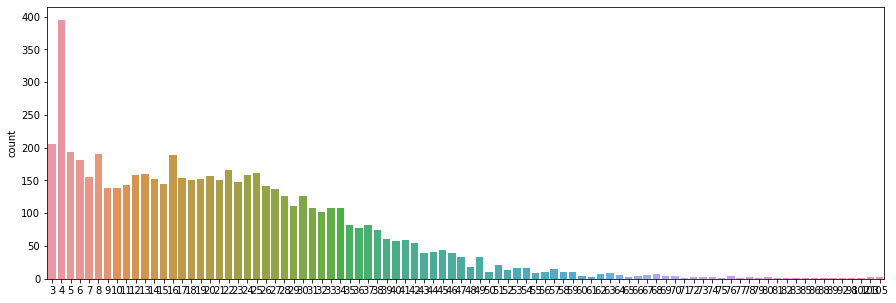

In [124]:
sen_lengths = [len(sent) for sent in sentences]
plt.figure(figsize=(15, 5))
sns.countplot(sen_lengths)

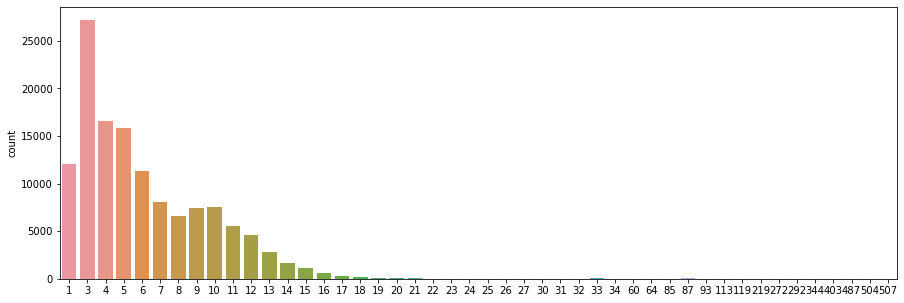

In [125]:
char_lengths = [len(t) for char in chars for t in char]
plt.figure(figsize=(15, 5))
sns.countplot(char_lengths)

In [126]:
train_sentences, valid_sentences, train_tags, valid_tags, train_chars, valid_chars = train_test_split(sentences, tags, chars, test_size=0.2, random_state=42)
valid_sentences, test_sentences, valid_tags, test_tags, valid_chars, test_chars = train_test_split(valid_sentences, valid_tags, valid_chars, test_size=0.5, random_state=42)
len(train_sentences), len(valid_sentences), len(test_sentences)

(4828, 603, 604)

In [127]:
class Vocab:
    def __init__(self, word2id, id2word):
        self.UNK = '<UNK>'
        self.PAD = '<PAD>'
        self.START = '<START>'
        self.END = '<END>'
        self.__word2id = word2id
        self.__id2word = id2word

    def get_word2id(self):
        return self.__word2id

    def get_id2word(self):
        return self.__id2word

    def __getitem__(self, item):
        if self.UNK in self.__word2id:
            return self.__word2id.get(item, self.__word2id[self.UNK])
        return self.__word2id[item]

    def __len__(self):
        return len(self.__word2id)

    def id2word(self, idx):
        return self.__id2word[idx]

In [128]:
def build_vocab(data, freq_cutoff=5, is_tags=False, is_chars=False):
    if is_chars:
        word_counts = Counter(chain(*chain(*train_chars[:10])))
    else:
        word_counts = Counter(chain(*data))
    valid_words = [w for w, d in word_counts.items() if d >= freq_cutoff]
    valid_words = sorted(valid_words, key=lambda x: word_counts[x], reverse=True)
    valid_words += ['<PAD>']
    word2id = {w: idx for idx, w in enumerate(valid_words)}
    if not is_tags:
        word2id['<UNK>'] = len(word2id)
        valid_words += ['<UNK>']
    return Vocab(word2id=word2id, id2word=valid_words)

In [129]:
words_vocab = build_vocab(train_sentences)
tags_vocab = build_vocab(train_tags, is_tags=True)
chars_vocab = build_vocab(train_chars, is_chars=True)

In [130]:
len(words_vocab), len(tags_vocab), len(chars_vocab)

(2622, 26, 45)

In [131]:
MAX_SEQ_LEN = 50
MAX_WORD_LEN = 15

In [132]:
class NERDataset(data.Dataset):
    def __init__(self, sentences, tags, chars, max_seq_len, max_word_len):
        self.sentences = sentences
        self.tags = tags
        self.characters = chars
        self.max_seq_len = max_seq_len
        self.max_word_len = max_word_len
    
    def __len__(self):
        return len(self.sentences)
    
    def __getitem__(self, item):
        sentence = self.sentences[item]
        tag = self.tags[item]
        chars = self.characters[item]
        seq_len = len(sentence)

        # convert the sentences and tags into numerical format
        word_tokens = [words_vocab[word] for word in sentence]
        tag_tokens = [tags_vocab[t] for t in tag]

        char_seq = []
        for word in chars:
            word_len = len(word)
            # truncate the word if it is greater than max_word_len
            if word_len > self.max_word_len:
                word = word[:self.max_word_len]
            # pad the word if it less
            else:
                pad_length = self.max_word_len - word_len
                word = word + [chars_vocab.PAD] * pad_length
            
            # convert the chars into numerical format
            char_ids = []
            for each_char in word: 
                char_ids.append(chars_vocab[each_char])
            char_seq.append(char_ids)
        
        return torch.LongTensor(word_tokens), torch.LongTensor(char_seq), torch.LongTensor(tag_tokens)

In [133]:
train_dataset = NERDataset(train_sentences, train_tags, train_chars, MAX_SEQ_LEN, MAX_WORD_LEN)
valid_dataset = NERDataset(valid_sentences, valid_tags, valid_chars, MAX_SEQ_LEN, MAX_WORD_LEN)
test_dataset = NERDataset(test_sentences, test_tags, test_chars, MAX_SEQ_LEN, MAX_WORD_LEN)

In [134]:
train_dataset[0]

(tensor([   0, 1217,    2, 2621, 2621, 2162,  507,    7,  462,    5, 2621,  174,
            3,   51,   74,   76,   28,   12, 1798,  581,   14,  817,    6, 2621,
            3,   18,  897,  230,  214,    3,  758,    1]),
 tensor([[24, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43],
         [ 1,  8,  2,  9, 25,  3, 11,  2,  8,  0, 43, 43, 43, 43, 43],
         [ 1, 26,  0, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43],
         [ 1, 37,  3, 14,  2,  0, 43, 43, 43, 43, 43, 43, 43, 43, 43],
         [ 1,  8, 15,  2,  5,  6,  0, 43, 43, 43, 43, 43, 43, 43, 43],
         [ 1,  7, 20,  6,  4,  3,  5,  3,  5, 21,  0, 43, 43, 43, 43],
         [ 1, 32,  9, 27, 32,  0, 43, 43, 43, 43, 43, 43, 43, 43, 43],
         [ 1,  4,  5, 12,  0, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43],
         [ 1, 16,  9,  2, 44, 17,  2,  5, 11, 18,  0, 43, 43, 43, 43],
         [ 1,  7, 16,  0, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43],
         [ 1, 15,  3, 11, 38,  0, 43, 43, 43, 43, 43, 43, 43, 43, 43]

In [135]:
BATCH_SIZE = 64

In [136]:
def collate_fn(data):
    data.sort(key=lambda x: len(x[0]), reverse=True)
    sentences, words, tags = zip(*data)

    # Merge questions (from tuple of 1D tensor to 2D tensor).
    sent_lengths = [len(sent) for sent in sentences]
    inputs = torch.zeros(len(sentences), max(sent_lengths)).long()
    labels = torch.zeros(len(sentences), max(sent_lengths)).long()
    chars = torch.zeros(len(sentences), max(sent_lengths), MAX_WORD_LEN).long()
    for i, (sent, lab, ch) in enumerate(zip(sentences, tags, words)):
        end = sent_lengths[i]
        inputs[i, :end] = sent[:end]
        labels[i, :end] = lab[:end]
        chars[i, :end] = ch[:end]
    return inputs, chars, labels, sent_lengths

In [137]:
train_data_loader = data.DataLoader(train_dataset, BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
valid_data_loader = data.DataLoader(valid_dataset, BATCH_SIZE, shuffle=False, collate_fn=collate_fn)
test_data_loader = data.DataLoader(test_dataset, BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

In [138]:
sample = next(iter(train_data_loader))

In [139]:
sample[0].shape, sample[1].shape, sample[2].shape, len(sample[3])

(torch.Size([64, 50]), torch.Size([64, 50, 15]), torch.Size([64, 50]), 64)

In [140]:
class CharBiLSTMCRF(nn.Module):
    def __init__(self, vocab_size, emb_dim, hid_dim, char_emb_dim, char_hid_dim, char_vocab_size, tag_vocab_size, sent_pad_token, tag_start_token, dropout=0.3):
        super().__init__()
        self.hid_dim = hid_dim
        self.sent_pad_token = sent_pad_token
        self.tag_start_token = tag_start_token
        self.tag_vocab_size = tag_vocab_size

        self.char_embedding = nn.Embedding(char_vocab_size, char_emb_dim, padding_idx=0)
        self.char_lstm = nn.LSTM(char_emb_dim, char_hid_dim, bidirectional=True, batch_first=True)

        self.embedding = nn.Embedding(vocab_size, emb_dim, padding_idx=0)
        self.lstm = nn.LSTM(
            emb_dim + char_hid_dim,
            hid_dim,
            bidirectional=True,
            batch_first=True
        )
        self.emission = nn.Linear(hid_dim * 2, tag_vocab_size)
        self.transition = nn.Parameter(torch.rand(tag_vocab_size, tag_vocab_size))

        self.dropout = nn.Dropout(dropout)
    
    def forward(self, sentences, lengths, words, tags):
        # sentences => [batch_size, seq_len]
        # lengths => [batch_size]
        # words => [batch_size, seq_len, word_len]
        # tags => [batch_size, seq_len]

        char_final_hidden = []
        for word in words:
            # word => [seq_len, word_len]
            char_embed = self.char_embedding(word)
            char_embed = self.dropout(char_embed)
            # char_embed => [seq_len, word_len, char_emb_dim]

            _, (char_hidden, _) = self.char_lstm(char_embed)
            # char_hidden => [2, seq_len, char_hid_dim]

            # add the final forward and backward hidden states
            char_combined = char_hidden[-1, :, :] + char_hidden[-2, :, :]
            # char_combined => [seq_len, char_hid_dim]

            char_final_hidden.append(char_combined)
        
        char_encoding = torch.stack(char_final_hidden)
        # char_encoding => [batch_size, seq_len, char_hid_dim]

        mask = (sentences != self.sent_pad_token).to(device)
        # mask => [batch_size, seq_len]

        embed = self.embedding(sentences)
        embed = self.dropout(embed)
        # embed => [batch_size, seq_len, emb_dim]

        embed_with_char = torch.cat((embed, char_encoding), dim=-1)
        # embed_with_char => [batch_size, seq_len, emb_dim + char_hid_dim]

        packed_input = nn.utils.rnn.pack_padded_sequence(embed_with_char, lengths, batch_first=True)
        packed_output, _ = self.lstm(packed_input)
        outputs, _ = nn.utils.rnn.pad_packed_sequence(packed_output, batch_first=True)
        # outputs => [batch_size, seq_len, hid_dim * 2]

        combined = torch.cat((outputs[:, :, :self.hid_dim], outputs[:, :, self.hid_dim:]), dim=-1)
        combined = self.dropout(combined)
        # combined => [batch_size, seq_len, hid_dim * 2]

        emission_scores = self.emission(combined)
        # emission_scores => [batch_size, seq_len, tag_size]

        loss = self.vitebri_loss(tags, mask, emission_scores)
        # loss => [batch_size]

        return loss

    def vitebri_loss(self, tags, mask, emit_scores):
        # tags => [batch_size, seq_len]
        # mask => [batch_size, seq_len]
        # emit_scores => [batch_size, seq_len, tag_size]

        batch_size, sent_len = tags.shape

        # calculate the ground truth score
        score = torch.gather(emit_scores, 2, tags.unsqueeze(2)).squeeze(2)
        # emission scores of actual tags
        # score => [batch_size, seq_len]

        # add the transition scores to the emission scores
        # ignore the start token tag score
        score[:, 1:] += self.transition[tags[:, :-1], tags[:, 1:]]

        # consider only the scores of actual tokens not the padded
        gold_scores = (score * mask.type(torch.float)).sum(dim=1)
        # gold_scores => [batch_size]

        # calculate the scores of the partition (Z)
        # tensor to hold the accumulated sequence scores at each time step
        # at the inital time step score will be on dim=0
        scores_upto_t = emit_scores[:, 0].unsqueeze(1)
        # scores_upto_t => [batch_size, 1, tag_size]

        for i in range(1, sent_len):
            # get the current batch_size
            batch_t = mask[:, i].sum()

            # get the accumulated scores till now (only the current batch size)
            scores_unpad = scores_upto_t[:batch_t]
            # scores_unpad => [batch_t, 1, tag_size]

            # add the transition scores for this time step
            scores_with_trans = emit_scores[:batch_t, i].unsqueeze(1) + self.transition
            # scores_with_trans => [batch_t, tag_size, tag_size]

            # add to the accumulation
            sum_scores = scores_unpad.transpose(1, 2) + scores_with_trans
            # sum_scores => [batch_t, tag_size, tag_size]
            
            # apply the following to overcome the overflow problems
            # since the exp(some_big_number) will cause issues 
            # log(Σ exp(z_k)) = max(z) + log(Σ exp(z_k - max(z)))
            # log(Σ exp(z_k)) = log(Σ exp(z_k - c + c))
            #                 = log(Σ exp(z_k - c) * exp(c))
            #                 = log(Σ exp(z_k - c)) + log(exp(c))
            #                 = log(Σ exp(z_k - c)) + c
            # by taking c as max(z)
            # log(Σ exp(z_k)) = max(z) + log(Σ exp(z_k - max(z))) [log_sum_exp]
            # get the maximum score of the current time step
            max_t = sum_scores.max(dim=1)[0].unsqueeze(1)
            # max_t => [batch_t, 1, tag_size]

            sum_scores = sum_scores - max_t
            # sum_scores => [batch_t, tag_size, tag_size]

            scores_t = max_t + torch.logsumexp(sum_scores, dim=1).unsqueeze(1)
            # scores_t => [batch_t, 1, tag_size]

            # update the accumulation scores
            scores_upto_t = torch.cat((scores_t, scores_upto_t[batch_t:]), dim=0)
            # scores_upto_t => [batch_size, 1, tag_size]
        
        final_scores = scores_upto_t.squeeze(1)
        # final_scores => [batch_size, tag_size]

        max_final_scores = final_scores.max(dim=-1)[0]
        # max_final_scores => [batch_size]

        predicted_scores = max_final_scores + torch.logsumexp(final_scores - max_final_scores.unsqueeze(1), dim=1)
        # predicted_scores => [batch_size]

        vitebri_loss = predicted_scores - gold_scores
        # vitebri_loss => [batch_size]

        return vitebri_loss
    
    def predict(self, sentences, lengths, words):
        # sentences => [batch_size, seq_len]
        # lengths => [batch_size]
        # words => [batch_size, seq_len, word_len]

        batch_size = sentences.size(0)

        char_final_hidden = []
        for word in words:
            # word => [seq_len, word_len]
            char_embed = self.char_embedding(word)
            char_embed = self.dropout(char_embed)
            # char_embed => [seq_len, word_len, char_emb_dim]

            _, (char_hidden, _) = self.char_lstm(char_embed)
            # char_hidden => [2, seq_len, char_hid_dim]

            # add the final forward and backward hidden states
            char_combined = char_hidden[-1, :, :] + char_hidden[-2, :, :]
            # char_combined => [seq_len, char_hid_dim]

            char_final_hidden.append(char_combined)
        
        char_encoding = torch.stack(char_final_hidden)
        # char_encoding => [batch_size, seq_len, char_hid_dim]

        mask = (sentences != self.sent_pad_token).to(device)
        # mask => [batch_size, seq_len]

        embed = self.embedding(sentences)
        embed = self.dropout(embed)
        # embed => [batch_size, seq_len, emb_dim]

        embed_with_char = torch.cat((embed, char_encoding), dim=-1)
        # embed_with_char => [batch_size, seq_len, emb_dim + char_hid_dim]

        packed_inp = nn.utils.rnn.pack_padded_sequence(embed_with_char, lengths, batch_first=True)
        packed_output, _ = self.lstm(packed_inp)
        outputs, _ = nn.utils.rnn.pad_packed_sequence(packed_output, batch_first=True)
        # outputs => [batch_size, seq_len, hid_dim * 2]

        combined = torch.cat((outputs[:, :, :self.hid_dim], outputs[:, :, self.hid_dim:]), dim=-1)
        combined = self.dropout(combined)
        # combined => [batch_size, seq_len, hid_dim * 2]

        emission_scores = self.emission(combined)
        # emission_scores => [batch_size, seq_len, tag_size]

        # to store the tags predicted at each time step
        # since at the begining every tag is start tag create the list with start tags
        tags = [[[self.tag_start_token] for _ in range(self.tag_vocab_size)]] * batch_size
        # tags => [batch_size, tag_size, 1]

        scores_upto_t = emission_scores[:, 0].unsqueeze(1)
        # scores_upto_t => [batch_size, 1, tag_size]

        for i in range(1, max(lengths)):
            # get the current batch_size
            batch_t = mask[:, i].sum()

            # get the accumulated scores till now (only the current batch size)
            scores_unpad = scores_upto_t[:batch_t]
            # scores_unpad => [batch_t, 1, tag_size]

            # add the transition scores for this time step
            scores_with_trans = emission_scores[:batch_t, i].unsqueeze(1) + self.transition
            # scores_with_trans => [batch_t, tag_size, tag_size]

            # add to the accumulation
            sum_scores = scores_unpad.transpose(1, 2) + scores_with_trans
            # sum_scores => [batch_t, tag_size, tag_size]

            max_scores_t, max_ids_t = torch.max(sum_scores, dim=1)
            max_ids_t = max_ids_t.tolist()
            # max_scores_t => [batch_t, tag_size]
            # max_ids_t => [batch_t, tag_size]

            # add the current time step predicted tags 
            tags[:batch_t] = [[tags[b][k] + [j] for j, k in enumerate(max_ids_t[b])] for b in range(batch_t)]
            
            # update the accumulation scores
            scores_upto_t = torch.cat((max_scores_t.unsqueeze(1), scores_upto_t[batch_t:]), dim=0)
            # scores_upto_t => [batch_size, tag_size]

        scores = scores_upto_t.squeeze(1)
        # scores => [batch_size, tag_size]

        _, max_ids = torch.max(scores, dim=1)
        max_ids = max_ids.tolist()
        # max_ids => [batch_size]

        # tags => [batch_size, tag_size, seq_len]
        tags = [tags[b][k] for b, k in enumerate(max_ids)]
        # tags => [batch_size, seq_len]

        return tags

In [142]:
vocab_size = len(words_vocab)
sent_pad_token = words_vocab[words_vocab.PAD]
tag_start_token = tags_vocab[tags_vocab.START]
emb_dim = 50
hid_dim = 200
char_emb_dim = 20
char_hid_dim = 50
char_vocab_size = len(chars_vocab)
tag_vocab_size = len(tags_vocab)
model = CharBiLSTMCRF(
    vocab_size,
    emb_dim,
    hid_dim,
    char_emb_dim,
    char_hid_dim,
    char_vocab_size,
    tag_vocab_size,
    sent_pad_token,
    tag_start_token
)
model.to(device)

CharBiLSTMCRF(
  (char_embedding): Embedding(45, 20, padding_idx=0)
  (char_lstm): LSTM(20, 50, batch_first=True, bidirectional=True)
  (embedding): Embedding(2622, 50, padding_idx=0)
  (lstm): LSTM(100, 200, batch_first=True, bidirectional=True)
  (emission): Linear(in_features=400, out_features=26, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)

In [143]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 655,102 trainable parameters


In [144]:
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [145]:
def train(model, iterator, optimizer, clip):
    model.train()

    epoch_loss = 0
    total_sentences = 0

    for batch in iterator:
        sentences = batch[0].to(device)
        words = batch[1].to(device)
        tags = batch[2].to(device)
        seq_lengths = batch[3]
        # sentences => [batch_size, seq_len]
        # words => [batch_size, seq_len, word_len]
        # tags => [batch_size, seq_len]
        # seq_lengths => [batch_size]

        optimizer.zero_grad()

        batch_loss = model(sentences, seq_lengths, words, tags)
        # batch_loss => [batch_size]

        loss = batch_loss.mean()

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        
        epoch_loss += batch_loss.sum().item()
        total_sentences += len(sentences)

    return epoch_loss / total_sentences

In [146]:
def evaluate(model, iterator):
    model.eval()
    epoch_loss = 0
    total_sentences = 0

    with torch.no_grad():
        for batch in iterator:
            sentences = batch[0].to(device)
            words = batch[1].to(device)
            tags = batch[2].to(device)
            seq_lengths = batch[3]
            # sentences => [batch_size, seq_len]
            # words => [batch_size, seq_len, word_len]
            # tags => [batch_size, seq_len]
            # seq_lengths => [batch_size]

            batch_loss = model(sentences, seq_lengths, words, tags)
            # batch_loss => [batch_size]

            loss = batch_loss.mean()

            epoch_loss += batch_loss.sum().item()
            total_sentences += len(sentences)
        
    return epoch_loss / total_sentences

In [147]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [148]:
N_EPOCHS = 10
CLIP = 2
best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):

    start_time = time.time()
    
    train_loss = train(model, train_data_loader, optimizer, CLIP)
    valid_loss = evaluate(model, valid_data_loader)
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'model.pt')
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Val. Loss: {valid_loss:.3f}')

Epoch: 01 | Epoch Time: 1m 24s
	Train Loss: 80.658 | Val. Loss: 20.857
Epoch: 02 | Epoch Time: 1m 27s
	Train Loss: 5.584 | Val. Loss: 2.295
Epoch: 03 | Epoch Time: 1m 25s
	Train Loss: 1.860 | Val. Loss: 1.641
Epoch: 04 | Epoch Time: 1m 25s
	Train Loss: 1.417 | Val. Loss: 1.556
Epoch: 05 | Epoch Time: 1m 26s
	Train Loss: 1.247 | Val. Loss: 1.429
Epoch: 06 | Epoch Time: 1m 25s
	Train Loss: 1.067 | Val. Loss: 1.380
Epoch: 07 | Epoch Time: 1m 26s
	Train Loss: 0.943 | Val. Loss: 1.342
Epoch: 08 | Epoch Time: 1m 24s
	Train Loss: 0.862 | Val. Loss: 1.392
Epoch: 09 | Epoch Time: 1m 25s
	Train Loss: 0.770 | Val. Loss: 1.301
Epoch: 10 | Epoch Time: 1m 20s
	Train Loss: 0.680 | Val. Loss: 1.371


In [154]:
model.load_state_dict(torch.load('model.pt'))

<All keys matched successfully>

In [155]:
test_loss = evaluate(model, test_data_loader)
print(f'Test Loss: {test_loss:.3f}')

Test Loss: 1.589


In [156]:
def cal_metrics(model, iterator):
    model.eval()

    fin_outputs = []
    fin_targets = []

    with torch.no_grad():
        for batch in iterator:
            sentences = batch[0].to(device)
            words = batch[1].to(device)
            tags = batch[2].to(device)
            seq_lengths = batch[3]
            # sentences => [batch_size, seq_len]
            # words => [batch_size, seq_len, word_len]
            # tags => [batch_size, seq_len]
            # seq_lengths => [batch_size]

            predictions = model.predict(sentences, seq_lengths, words)
            # predictions => [batch_size, seq_len]

            fin_outputs.extend(predictions)
            fin_targets.extend(tags.detach().cpu().numpy().tolist())
        
    assert len(fin_outputs) == len(fin_targets)
    mlb = MultiLabelBinarizer()
    trans_trg = mlb.fit_transform(fin_targets)
    trans_pred = mlb.transform(fin_outputs)

    cf = metrics.classification_report(trans_trg, trans_pred)
    print(cf)

In [157]:
cal_metrics(model, test_data_loader)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       604
           1       1.00      1.00      1.00       604
           2       1.00      1.00      1.00       604
           3       0.91      0.88      0.90        49
           4       0.63      0.80      0.70        54
           5       0.87      0.91      0.89        22
           6       0.57      0.75      0.65        28
           7       1.00      0.81      0.89        36
           8       0.96      0.71      0.81        34
           9       0.95      0.75      0.84        24
          10       0.89      0.74      0.81        23
          11       0.88      0.44      0.58        16
          12       1.00      0.57      0.73        14
          13       0.67      0.55      0.60        11
          14       1.00      0.67      0.80         9
          15       0.60      0.50      0.55         6
          16       1.00      0.62      0.77         8
          17       0.75    

In [158]:
def inference(sentence):
    if isinstance(sentence, str):
        tokens = [words_vocab[words_vocab.START]] + sentence.split() + [words_vocab[words_vocab.END]]
    else:
        tokens = sentence
    
    chars = [['<START']] + [['<START>'] + [ch for ch in word] + ['<END>'] for word in tokens[1:-1]] + [['<END>']]

    char_seq = []
    for word in chars:
        word_len = len(word)
        # truncate the word if it is greater than max_word_len
        if word_len > MAX_WORD_LEN:
            word = word[:MAX_WORD_LEN]
        # pad the word if it less
        else:
            pad_length = MAX_WORD_LEN - word_len
            word = word + [chars_vocab.PAD] * pad_length
        
        # convert the chars into numerical format
        char_ids = []
        for each_char in word: 
            char_ids.append(chars_vocab[each_char])
        char_seq.append(char_ids)

    # numericalize
    token_ids = [words_vocab[tok] for tok in tokens]
    
    # seq length
    sent_length = [len(token_ids)]

    # create tensors
    sent_tensor = torch.LongTensor(token_ids).to(device)
    sent_tensor = sent_tensor.unsqueeze(0)
    # sent_tensor => [1, seq_len]

    char_tensor = torch.LongTensor(char_seq).to(device)
    char_tensor = char_tensor.unsqueeze(0)
    # char_tensor => [1, seq_len, word_len]

    model.eval()
    with torch.no_grad():
        predictions = model.predict(sent_tensor, sent_length, char_tensor)
    
    predictions = predictions[0]
    predicted_tags = []
    for i in predictions:
        predicted_tags.append(tags_vocab.id2word(i))
    
    return tokens, predicted_tags

In [159]:
sentence = test_sentences[0]
actual_tags = test_tags[0]
tokens, predicted_tag_ids = inference(sentence)

print("Pred. Tag\tActual Tag\tCorrect?\tToken\n")
for token, pred_tag, actual_tag in zip(tokens, predicted_tag_ids, actual_tags):
    correct = '✔' if pred_tag == actual_tag else '✘'
    print(f"{pred_tag}\t\t{actual_tag}\t\t{correct}\t\t{token}")

Pred. Tag	Actual Tag	Correct?	Token

<START>		<START>		✔		<START>
O		O		✔		Developing
O		O		✔		small
O		O		✔		molecule
O		O		✔		agonistic
O		O		✔		ligands
O		O		✔		for
O		O		✔		tyrosine
O		O		✔		kinase
O		O		✔		receptors
O		O		✔		has
O		O		✔		been
O		O		✔		difficult
O		O		✔		,
O		O		✔		and
O		O		✔		it
O		O		✔		is
O		O		✔		generally
O		O		✔		thought
O		O		✔		that
O		O		✔		such
O		O		✔		ligands
O		O		✔		require
O		O		✔		bivalency
O		O		✔		.
<END>		<END>		✔		<END>


In [160]:
sentence = test_sentences[10]
actual_tags = test_tags[10]
tokens, predicted_tag_ids = inference(sentence)

print("Pred. Tag\tActual Tag\tCorrect?\tToken\n")
for token, pred_tag, actual_tag in zip(tokens, predicted_tag_ids, actual_tags):
    correct = '✔' if pred_tag == actual_tag else '✘'
    print(f"{pred_tag}\t\t{actual_tag}\t\t{correct}\t\t{token}")

Pred. Tag	Actual Tag	Correct?	Token

<START>		<START>		✔		<START>
O		O		✔		newborn
O		O		✔		pigs
O		O		✔		.
O		O		✔		To
O		O		✔		investigate
O		O		✔		the
O		O		✔		potential
O		O		✔		role
O		O		✔		of
O		O		✔		sympathetic
O		B-Multi-tissue_structure		✘		nerves
O		O		✔		in
O		O		✔		preventing
O		O		✔		pronounced
O		O		✔		increases
O		O		✔		in
B-Organ		B-Organ		✔		cerebral
B-Organism_substance		B-Organism_substance		✔		blood
<END>		<END>		✔		<END>


In [161]:
sentence = "Vibrissae are tactile hairs found mainly on the rostrum of most mammals. The follicle, which is surrounded by a large venous sinus, is called 'follicle‐sinus complex' (FSC). This complex is highly innervated by somatosensitive fibers and reached by visceromotor fibers that innervate the surrounding vessels. The surrounding striated muscles receive somatomotor fibers from the facial nerve. The bottlenose dolphin (Tursiops truncatus), a frequently described member of the delphinid family, possesses this organ only in the postnatal period. However, information on the function of the vibrissal complex in this latter species is scarce. Recently, psychophysical experiments on the river‐living Guiana dolphin (Sotalia guianensis) revealed that the FSC could work as an electroreceptor in murky waters. In the present study, we analyzed the morphology and innervation of the FSC of newborn (n = 8) and adult (n = 3) bottlenose dolphins. We used Masson's trichrome stain and antibodies against neurofilament 200 kDa (NF 200), protein gene product (PGP 9.5), substance P (SP), calcitonin gene‐related peptide, and tyrosine hydroxylase (TH) to characterize the FSC of the two age classes."
tokens, predicted_tag_ids = inference(sentence)

print("Pred. Tag\tToken\n")
for token, pred_tag in zip(tokens[1:-1], predicted_tag_ids[1:-1]):
    print(f"{pred_tag}\t\t{token}")

Pred. Tag	Token

O		Vibrissae
O		are
O		tactile
O		hairs
O		found
O		mainly
O		on
O		the
B-Multi-tissue_structure		rostrum
O		of
O		most
O		mammals.
O		The
O		follicle,
O		which
O		is
O		surrounded
O		by
O		a
O		large
B-Multi-tissue_structure		venous
O		sinus,
O		is
O		called
O		'follicle‐sinus
O		complex'
O		(FSC).
O		This
O		complex
O		is
O		highly
O		innervated
O		by
O		somatosensitive
B-Organ		fibers
O		and
O		reached
O		by
B-Tissue		visceromotor
I-Tissue		fibers
O		that
O		innervate
O		the
B-Multi-tissue_structure		surrounding
I-Multi-tissue_structure		vessels.
O		The
O		surrounding
O		striated
B-Tissue		muscles
I-Tissue		receive
I-Tissue		somatomotor
I-Tissue		fibers
O		from
O		the
B-Multi-tissue_structure		facial
I-Multi-tissue_structure		nerve.
O		The
O		bottlenose
O		dolphin
O		(Tursiops
O		truncatus),
O		a
O		frequently
O		described
O		member
O		of
O		the
O		delphinid
O		family,
O		possesses
O		this
B-Organ		organ
O		only
O		in
O		the
O		postnatal
O		period.
O		However,
O		in